Project FILIÈRE RECHERCHE

Under the supervision of :

Elisabeth Lahalle

Students :

- Ricardo Chiquetto do Lago
- Maxsuel Fernandes de Almeida
- Samara Ndiaye
- Ana Cecilia Reghini
- Lucas Tramonte

# Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

# Data

In [13]:
data_gamma_irradiation = pd.read_csv("Assets/Data/2015_months_DebitDoseA.csv")
data_hygometry = pd.read_csv("Assets/Data/2015_months_HYGR.csv")
data_patm = pd.read_csv("Assets/Data//2015_months_PATM.csv")
data_temp = pd.read_csv("Assets//Data//2015_months_TEMP.csv")

In [14]:
#data_gamma_irradiation

# Data Visualization

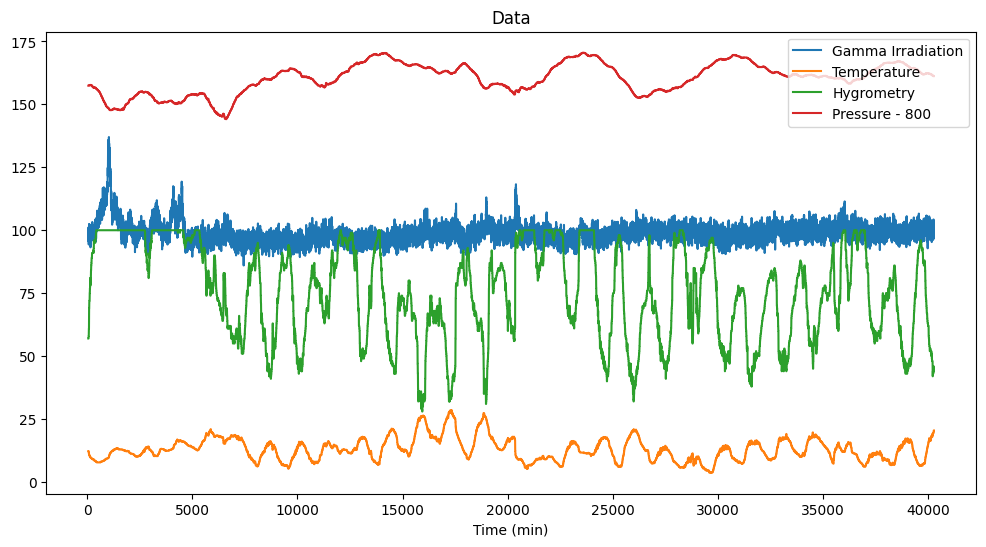

In [15]:
# Define the month (1: February, 2: April, 3: June, 4: October)
month = 2 # selected month: June

# Extract data for the selected month
sigg = data_gamma_irradiation.iloc[:, month-1]  # Gamma irradiation data
sigt = data_temp.iloc[:, month-1]               # Temperature data
sigh = data_hygometry.iloc[:, month-1]          # Hygrometry data
sigp = data_patm.iloc[:, month-1]               # Atmospheric pressure data

# Remove the first and last hour of data
N = len(sigg)  # number of data points
fe = 1/60      # sampling frequency
t = list(range(N))  # time vector

Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_trimmed, sigg[Nh:N-Nh], label='Gamma Irradiation')
plt.plot(t_trimmed, sigt[Nh:N-Nh], label='Temperature')
plt.plot(t_trimmed, sigh[Nh:N-Nh], label='Hygrometry')
plt.plot(t_trimmed, sigp[Nh:N-Nh] - 800, label='Pressure - 800')

plt.xlabel('Time (min)')
plt.title('Data')
plt.legend()
plt.show()


## Ploting the 5 months

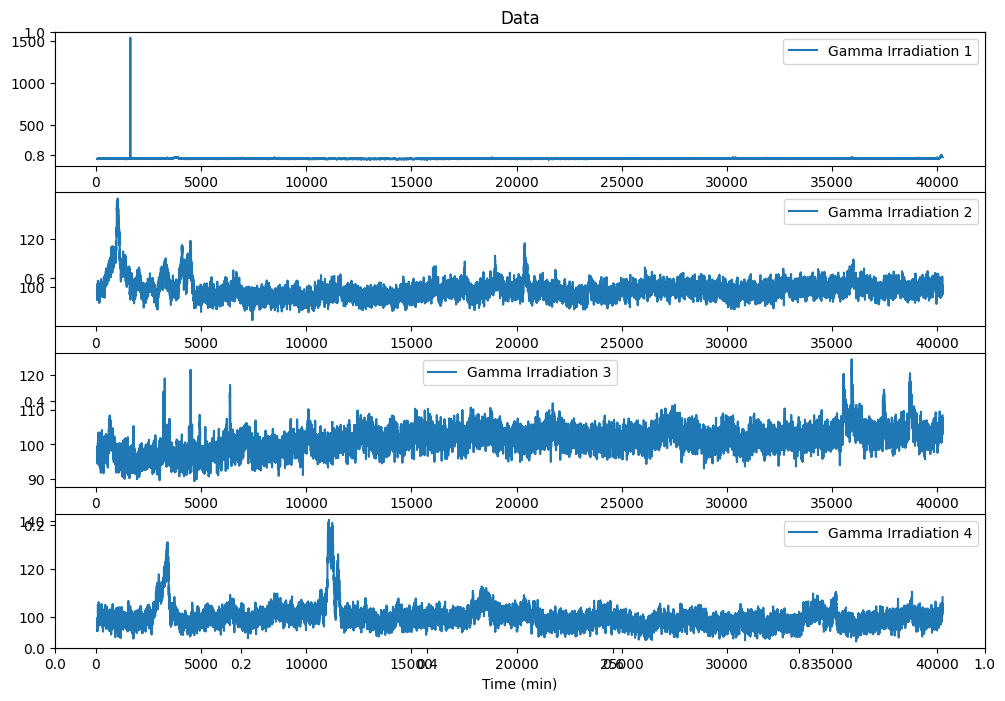

In [16]:
plt.figure(figsize=(12, 8))
plt.title('Data')

for i in range(4):
    plt.subplot(4, 1, i+1)

    # Remove the first and last hour of data
    Nh = 60  # 1 hour
    t_trimmed = t[Nh:N-Nh]

    # Plot the data
    plt.plot(t_trimmed, data_gamma_irradiation.iloc[:, i][Nh:N-Nh], label=f'Gamma Irradiation {i+1}')
    plt.legend()
    
plt.xlabel('Time (min)')


plt.show()


## Outlier removing

In [17]:
from scipy.ndimage import binary_dilation

# Define a structuring element (for example, a window of size 3)
structure = np.ones(5)  # A window of size 3 will dilate 'True' values to neighboring points

# replace all values above 1000 with the average of the two surrounding values
def remove_outliers(s, threshold=800):
    s = s.copy()
    idx = s > threshold
    # Apply binary dilation
    expanded_series = binary_dilation(idx, structure=structure)
    mu = s.mean()
    s[expanded_series] = mu
    return s
    


def drop_max(s):
    idx = s.argmax()
    print(f"Max value at index {idx}")
    mu = (s[idx+1] + s[idx-1]) / 2
    s[idx] = mu
    return s

In [18]:
filtered_data = data_gamma_irradiation.copy()
filtered_data.iloc[:, 0] = remove_outliers(data_gamma_irradiation.iloc[:, 0])

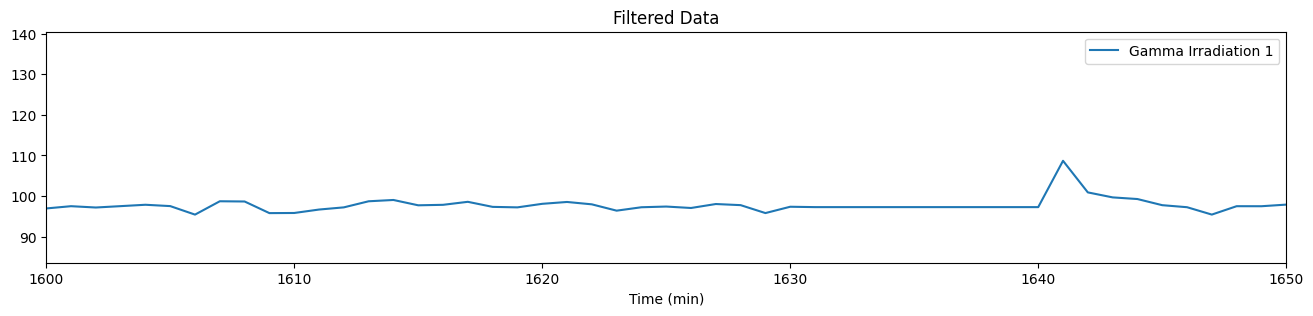

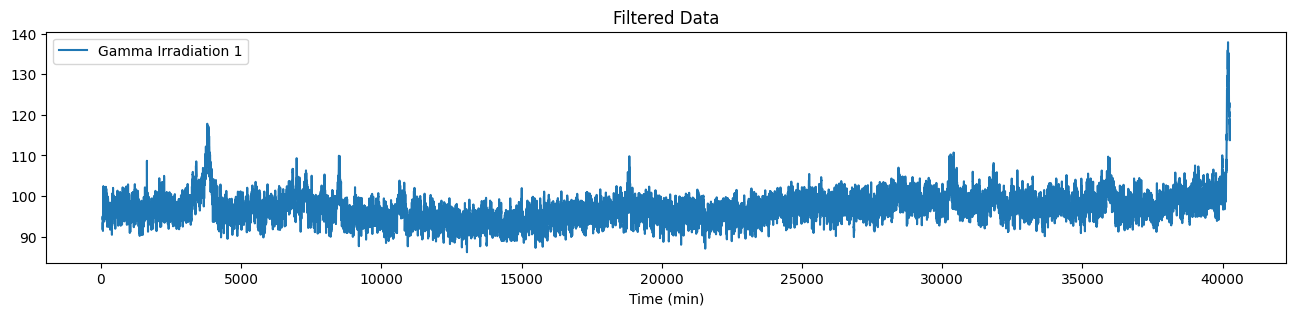

In [23]:


# Remove the first and last hour of data
Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(16, 3))
plt.title('Filtered Data')
plt.plot(t_trimmed, filtered_data.iloc[:, 0][Nh:N-Nh], label=f'Gamma Irradiation 1')
plt.legend()
plt.xlabel('Time (min)')
plt.xlim(1600,1650)
plt.show()

plt.figure(figsize=(16, 3))
plt.title('Filtered Data')
plt.plot(t_trimmed, filtered_data.iloc[:, 0][Nh:N-Nh], label=f'Gamma Irradiation 1')
plt.legend()
plt.xlabel('Time (min)')
plt.show()

## SDT method to detect collectif motifs

In [20]:
def compute_moving_mean(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).mean()

def compute_moving_std(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).std()


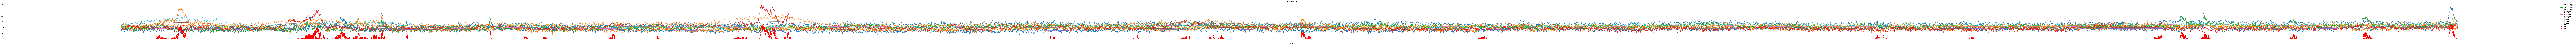

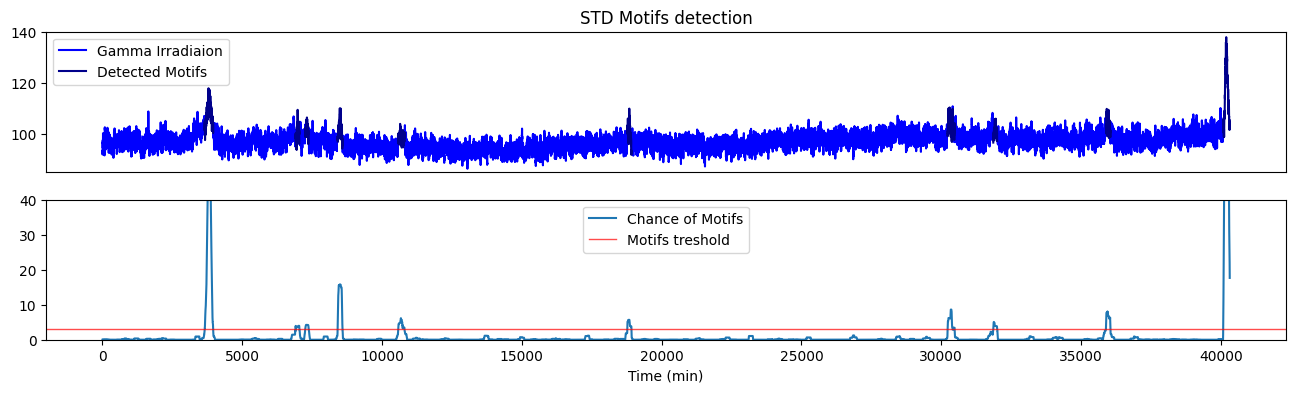

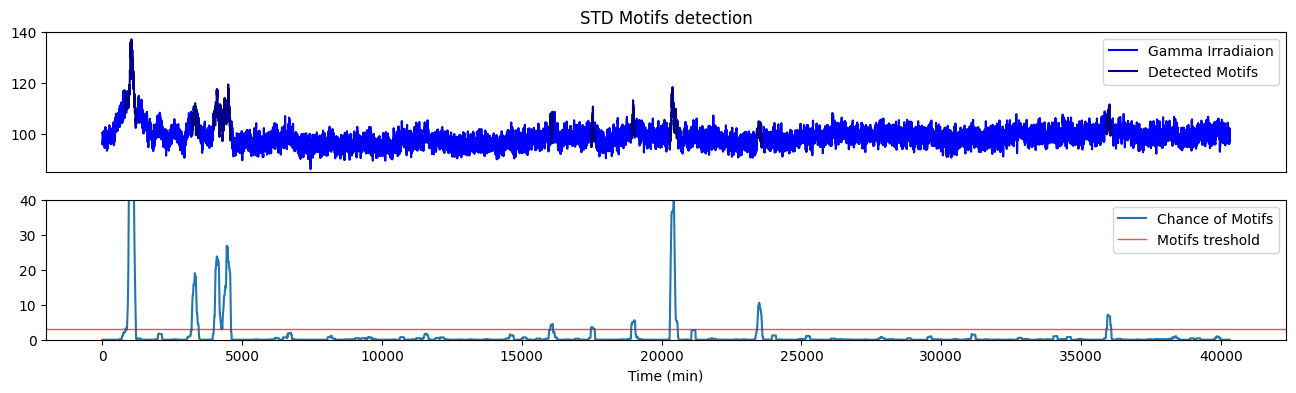

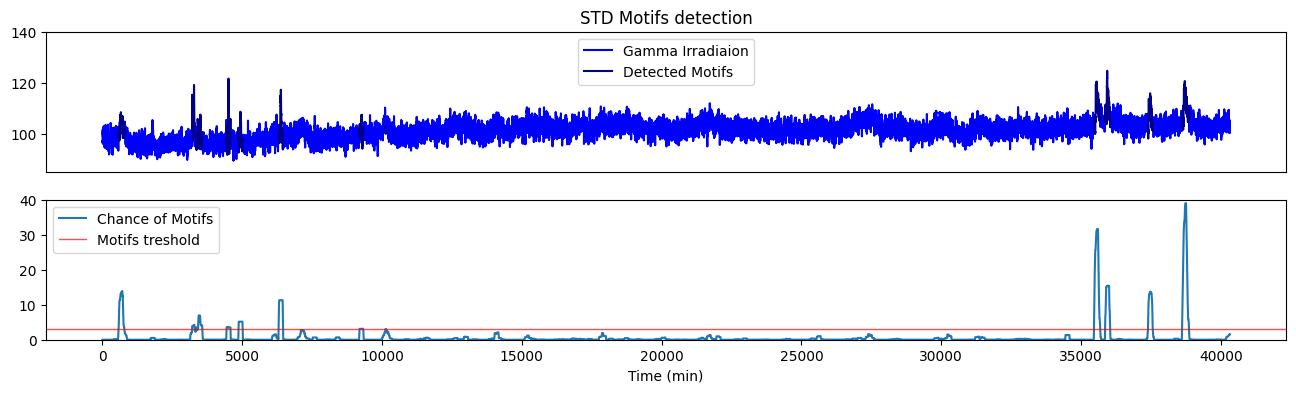

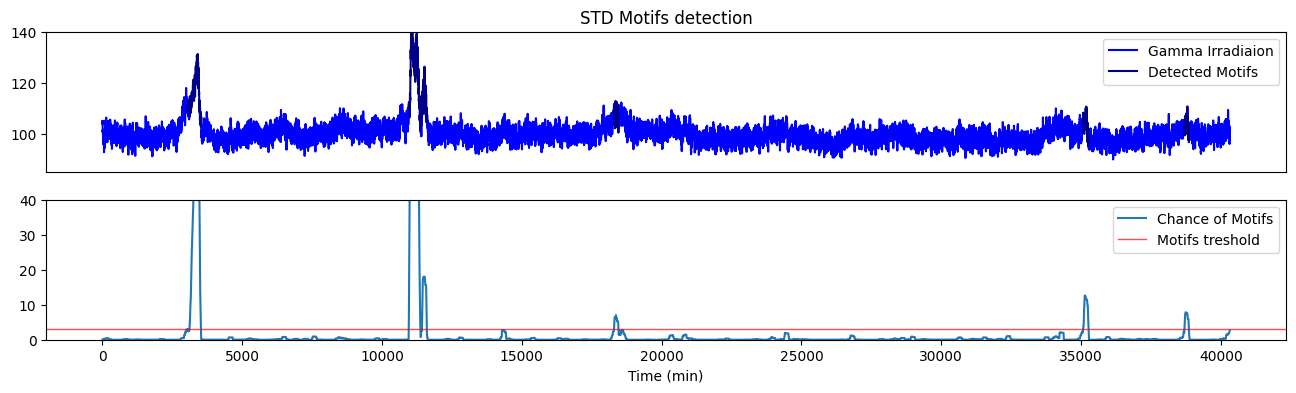

In [21]:
import numpy as np
signal = filtered_data.iloc[:, :]  # Select the signal points
time = t  # Select the time points

lw = 20  # Window length for moving standard deviation (75)
n = 70  # Window length multiplyer for moving mean

# Step 1: Compute the moving mean with window size n*lw
moving_mean = compute_moving_mean(signal, window_size=n*lw)

# Step 2: Compute the moving standard deviation with window size lw
moving_std = compute_moving_std(signal, window_size=lw)

# Step 3: Compute the threshold as moving_mean + 3 * moving_std
threshold = moving_mean + 3 * moving_std

# Step 4: Find points in the signal that exceed the threshold
dif = signal - threshold
dif[dif < 0] = 0

# Step 5: Log func definition
def log_func(x):
    return np.log(x) if x > np.e else 0

# Step 6: Motifs detection
coef = 10 # Multiplicative factor for the moving mean
dif_mean = compute_moving_mean(dif, 150)*coef # Moving mean of dif
th = 0.3*coef # Threshold of dif for motifs
motifs = signal[dif_mean > th]
plotable_dif = dif[dif_mean > th]
    
# Plot the data
plt.figure(figsize=(400, 6))
plt.plot(time, signal, label='Gamma Irradiaion')
plt.plot(time, moving_mean, label='Moving Mean')
plt.plot(time, threshold, label='Threshold')
#plt.plot(motifs, 'ro', label='Motifs')
plt.plot(80 + plotable_dif, 'ro', label='Motifs')
plt.xlabel('Time (min)')
plt.title('STD Motifs detection')
plt.legend()

for i in range(4):
    plt.figure(figsize=(16, 4))
    
    plt.subplot(2, 1, 1)
    plt.title('STD Motifs detection')
    plt.plot(time, signal[dif_mean<th].iloc[:,i], label='Gamma Irradiaion', color="blue")
    plt.plot(time, signal[dif_mean>=th].iloc[:,i], label='Detected Motifs', color="darkblue")
    plt.ylim(85, 140)
    plt.xticks([])
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(time, dif_mean.iloc[:,i], label='Chance of Motifs')
    plt.axhline(y=th, color='red', label='Motifs treshold', linestyle='-', linewidth=1, alpha=0.7,)
    plt.ylim(0, 40)
    plt.xlabel('Time (min)')
    plt.legend()



# LSTMs